# <font color='EC2C04'> RHODE ISLAND POLICE STOPPING: Overview of the factors contributing to the arrest following a Police vehicle stopping </font>
 

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

---

# <font color='EC2C04'> IMPORT THE DATA </font>

In [2]:
df1 = pd.read_csv('RI_police.csv', low_memory=False)

In [3]:
df = df1.copy() # I keep the original file, in case I will need to get access to it
#df.head()

---

# <font color='EC2C04'> DATA WRANGLING </font> 

## 1. Filter The Data < 2007 

Filtering the data keeping only observation > 2007

In [4]:
# Set stop_date as a datetime index in order to filter the data 
df['stop_date'] = pd.to_datetime(df['stop_date'])
df.set_index('stop_date', inplace= True)
df = df['2007':'2015']

# Reset the index, in order to work on the variable stop_date later if necessary
df.reset_index(inplace= True)

In [5]:
# Verify the shape of the dataset
print(' Number of Observation/accidents:', df.shape[0],'\n','Number of Variables',df.shape[1] )

 Number of Observation/accidents: 437249 
 Number of Variables 26


## 2. Analysis of Missing Values

In [6]:
df.isnull().sum()

stop_date                     0
id                            0
state                         0
stop_time                     0
location_raw                  0
county_name              437249
county_fips              437249
fine_grained_location    437249
police_department             0
driver_gender             26026
driver_age_raw            26002
driver_age                27339
driver_race_raw           26005
driver_race               26005
violation_raw             26005
violation                 26005
search_conducted              0
search_type_raw          422284
search_type              422284
contraband_found              0
stop_outcome              26005
is_arrested               26005
stop_duration             26005
out_of_state              26537
drugs_related_stop            0
district                      0
dtype: int64

### . Drop Columns with elevate numbers of Nan's

In [7]:
df = df.drop(['county_name', 'county_fips', 'fine_grained_location'], axis=1) # Nan's = len(df)

*Search_type* may have missing values due to the fact that they correspond to the *search_conducted* outcome == False.
In other words, when a search is not conducted ( indicated with value == False ) no search_type is obviously recorded. 

In [8]:
print('', df.search_conducted.value_counts()[0], # search_conducted == False
      'times out of', len(df), ' no search has been conducted.\n',
      df.search_type.isnull().sum(), 'missing values for "seach_type" variable')

 422284 times out of 437249  no search has been conducted.
 422284 missing values for "seach_type" variable


The hypotesis seems to be proven. As a consequence, the missing values in the variable *search_type* will be replaced with 'no search conducted'

In [9]:
df['search_type'] = df.search_type.fillna('no search conducted') # Replace Nan with 'no search conducted'

### . Drop Rows with Nan's distribuited over many columns

In [10]:
df = df.dropna(subset= ['driver_gender', 'driver_age','out_of_state']) 

# The missing values for the other columns were the same of these, so no variable will have Nan's anymore
# except search_type_raw, but it will be deleted like any other 'raw' variable

In [11]:
#df.isnull().sum() # check NA again

## 3. Modifying the Variable

In [12]:
# Drop the id, written too complicately with no need, and replace it with a simple one.

df['ID'] = range(1,(len(df)+1))    # New ID
df.drop('id',axis = 1, inplace= True) # Drop the old ID

In [13]:
# Drop STATE cause the analysis regards one State only (RI)

print('Column contains only one unique category:', df.state.unique())
df.drop('state',axis = 1, inplace= True)

Column contains only one unique category: ['RI']


In [14]:
# RAW ones not useful, cause they repeat the standardized ones
df.drop(['location_raw','driver_age_raw', 'driver_race_raw', 
         'violation_raw', 'search_type_raw', 'out_of_state'], axis = 1, inplace= True )

## 4. Categories

In [15]:
df.dtypes 

stop_date             datetime64[ns]
stop_time                     object
police_department             object
driver_gender                 object
driver_age                   float64
driver_race                   object
violation                     object
search_conducted              object
search_type                   object
contraband_found                bool
stop_outcome                  object
is_arrested                   object
stop_duration                 object
drugs_related_stop              bool
district                      object
ID                             int64
dtype: object

In [16]:
# CONVERT VARIABLES TYPES

# Function to make the process quicker
def turn(variable, cat):
    df[variable] = df[variable].astype(cat)

turn('is_arrested', 'bool')
turn('search_conducted', 'bool')
turn('driver_age', 'int')

# Convert all the other into nominal categorical
for x,v in zip(df.columns, df.dtypes): 
    if v == 'object':
        turn(x,'category')
        

# Convert into Ordinal Categorical
# df.stop_duration.unique() # Verifying the categories
duration = ['0-15 Min', '16-30 Min','30+ Min', '1'] # Set the order
df.stop_duration = df.stop_duration.astype(CategoricalDtype(ordered=True, categories= duration))

In [17]:
# CREATE DATETIME FORMAT 

df['stop_date'] = df.stop_date.astype('str') # Convert it back to string as I previously had to convert it for filtering purposes

# Concatenate, create new variable and convert it to datetime
stop_datetime = df.stop_date.str.cat(df.stop_time, sep = '  ')
df['stop_datetime'] = pd.to_datetime(stop_datetime)

# drop old columns
df = df.drop(['stop_date', 'stop_time'], axis = 1)

# set stop_datetime as index
df.set_index('stop_datetime', inplace= True)

In [18]:
# CREATE VARIABLE TO COUNT stops 
df['stops'] = 1

---

In [19]:
# Check the dataset before the analysis

# df.dtypes
# df.shape

---

# <font color='EC2C04'> EXPLORATORY ANALYSIS</font> 


## Part.1: Description of the variables

This section aims to provide an overview of the variables in order to obtain a better understanding of the analysed phenomena.

In [33]:
sns.set_context("paper")
plt.style.use('ggplot')

### . Verify the Phaenomena of Arresting

The following is a brief introductive analysis of the average of people arrested every year in Rhode Island after a stopping by the Police.

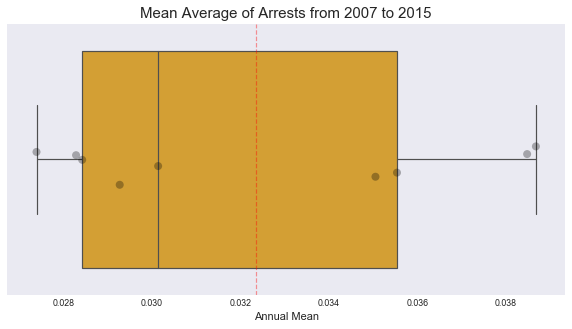

45486.0

In [21]:
arrested = df.groupby(df.index.year).is_arrested.mean() # Annual mean of people arrested

ax = plt.figure(figsize=(10, 5))
sns.boxplot(arrested, color="#eda81a")

# add a line towards the mean value
plt.axvline(arrested.mean(), color="red", linestyle="--", alpha = 0.4)

# add the dots corresponding to the annual means 
ax = sns.stripplot(arrested, color="black", jitter=0.10, size=8, alpha = 0.3)

plt.xlabel('Annual Mean', fontsize = 11)
plt.title('Mean Average of Arrests from 2007 to 2015', fontsize = 15)
plt.show()

df.groupby(df.index.year).is_arrested.count().mean() # Verify the number of people arrested



### . Brief Analysis of Facts regarding Police Stopping

/Users/simonezanetti/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


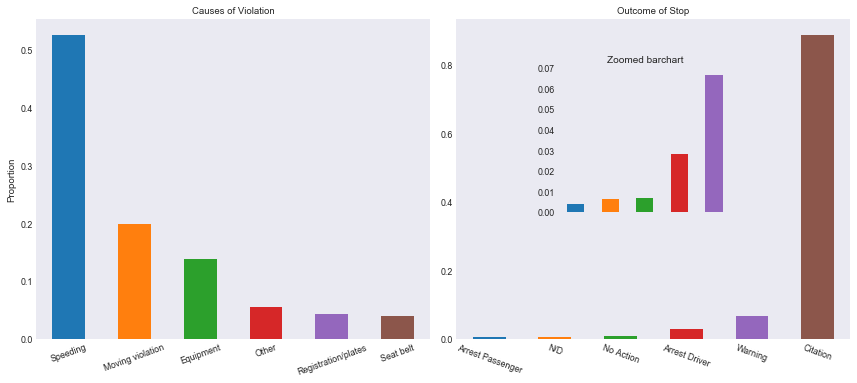

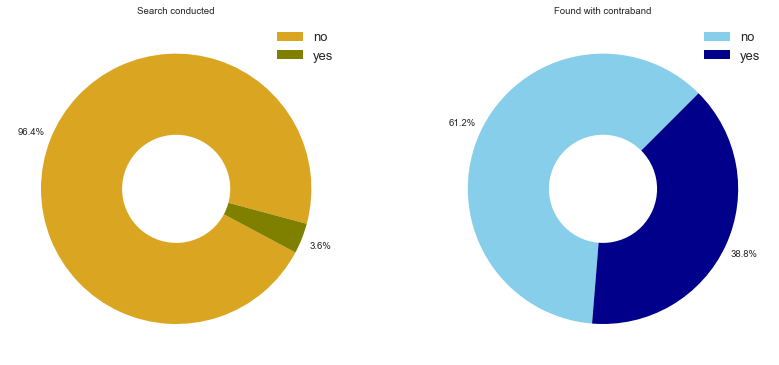

In [28]:
fig = plt.subplots(1, 2, figsize=(12,10))

# VIOLATIONS
plt.subplot(2,2,1) 
violation = df.violation.value_counts(ascending=False, normalize= True)
violation.plot(kind = 'bar', rot = 20)
plt.title('Causes of Violation')
plt.ylabel('Proportion')

# STOP OUTCOME
plt.subplot(2,2,2) 
stop_outcome = df.stop_outcome.value_counts(ascending=True, normalize= True)
stop_outcome.plot(kind = 'bar', rot = -20)
plt.title('Outcome of Stop')
# insert a zoomed barchart
plt.axes([0.65, 0.70, 0.20, 0.20])
stop_outcome.plot(kind = 'bar', rot = 0)
plt.title('Zoomed barchart', fontsize = 10)
plt.xticks([])
plt.ylim(0,0.070)
plt.xlim(-0.5,4.5)

plt.tight_layout()
plt.show()


fig = plt.subplots(1, 2, figsize=(12,10))

# SEARCH CONDUCTED 
plt.subplot(2,2,3) 

search_conducted = df.search_conducted.value_counts(normalize=True)
colors = ['goldenrod', 'olive']
label = ('no','yes')
plt.pie(search_conducted, colors = colors, autopct='%1.1f%%', startangle=-15, pctdistance=1.15)
#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(label, fontsize= 13)
plt.title('Search conducted')

# CONTRABAND FOUND
plt.subplot(2,2,4)

searched = df[df['search_conducted']]
contraband_found = searched.contraband_found.value_counts(normalize=True)
#colors
colors = ['skyblue','darkblue']
label = ('no', 'yes')
plt.pie(contraband_found, colors = colors, autopct='%1.1f%%', startangle=45, pctdistance=1.15)
plt.legend(label, fontsize= 13)
#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Found with contraband')


plt.tight_layout()
plt.show()

### . Age

In [29]:
#age = df.driver_age.value_counts(sort = False) # Count the number of drivers in each age
#age = age.to_frame()
a = df.reset_index()
arr_only = df[df.is_arrested] # Filtered for only those arrested
b = arr_only.reset_index()

/Users/simonezanetti/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


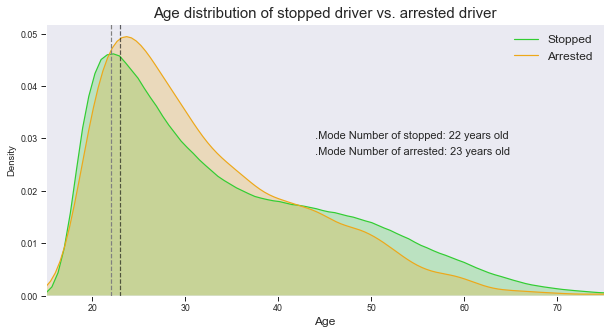

In [30]:
# COMPARE AGE DISTRIBUTION FOR STOPPED DRIVERS vs. ARRESTED DRIVERS

sns.set_context("paper")
ax = plt.figure(figsize=(10, 5))

# Create the Density plots
sns.kdeplot( a.driver_age , color="limegreen", label="Stopped", shade = True, cut = 0)
sns.kdeplot( b.driver_age , color="#eda81a", label="Arrested", shade = True, cut = 0)

# Add a line at the max value of people arrested and people stopped
plt.axvline(df.driver_age.value_counts().idxmax(), color="grey", linestyle="--");
plt.axvline(b.driver_age.value_counts().idxmax(), color="k", linestyle="--", alpha = 0.6);

# Set labels
plt.title('Age distribution of stopped driver vs. arrested driver', fontsize = 15)
plt.xlabel('Age',fontsize = 12)
plt.ylabel('Density')
plt.annotate('.Mode Number of stopped: '+ str(df.driver_age.value_counts().idxmax())+ ' years old',xy=(44,0.03) , fontsize = 11)
plt.annotate('.Mode Number of arrested: '+ str(b.driver_age.value_counts().idxmax())+ ' years old', xy=(44,0.027), fontsize = 11)


# Customise 
plt.xlim(15,75)
plt.legend(fontsize= 12)
plt.show()

### . Gender

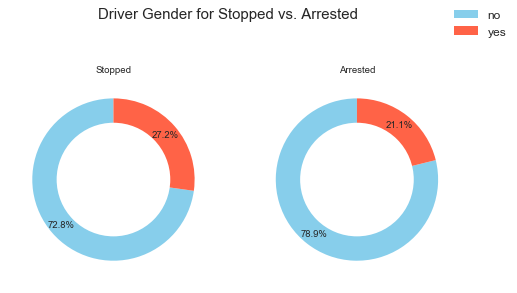

In [31]:
fig = plt.subplots(1, 2, figsize=(8,5))
plt.style.use('seaborn-deep')

plt.suptitle('Driver Gender for Stopped vs. Arrested', fontsize = 15)

plt.subplot(1,2,1)
gender = df.driver_gender.value_counts()
#colors
colors = ['skyblue','tomato']
plt.pie(gender, colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Stopped')

# --------
plt.subplot(1,2,2)
c = b.driver_gender.value_counts()

plt.pie(c, colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Arrested')


fig.legend(labels = label, fontsize = 12)
plt.show()


### . Race

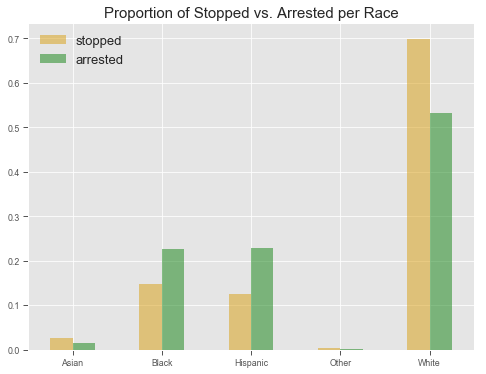

In [36]:
race = df.driver_race.value_counts(normalize= True)

# Race arrested
race_arrested = b.driver_race.value_counts()
race_arrested = race_arrested/race_arrested.sum()  # normalisation 
race_arrested = race_arrested.to_frame()
race_arrested.rename(columns= {'driver_race':'arrested'}, inplace= True) # avoid same name for diff.variable

# Concatenate
o = pd.concat([race, race_arrested], axis='columns')
o.rename(columns={'driver_race':'stopped'}, inplace = True) # change variable name for the legend

col = ["goldenrod","forestgreen"]
o.plot(kind = 'bar', color = col, alpha = 0.55, rot = 0, figsize= (8,6) )

plt.title('Proportion of Stopped vs. Arrested per Race', fontsize = 15)
plt.legend(fontsize = 13)

plt.show()

---

## Part 2: Relationship between demographic factors and people arrested 

---

### Consistency between Age and Gender trend 

The following analysis verify the percentage of arrests for each age. In other words, what is the proportion of people arrested for each age, observing the trend for both Male and Female.

In [1304]:
arrested = df.groupby(['driver_age','driver_gender']).is_arrested.mean()
arrested.sort_values(ascending=False,inplace = True)
arrested = arrested.to_frame().reset_index()
arrested = arrested[arrested.is_arrested > 0.001]


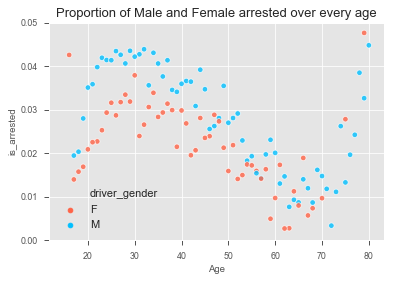

In [1305]:
sns.set_context("paper")
colors = {'F':'tomato', 'M':'deepskyblue'}
plt.ylim(0,0.05) # It takes off the outlier of 15 years old where obviously the probability is very high.

sns.scatterplot(arrested.driver_age, arrested.is_arrested, hue = arrested.driver_gender, 
                palette = colors,s = 30, alpha = 0.8)


plt.xlabel('Age')
plt.title('Proportion of Male and Female arrested over every age', fontsize = 13)
plt.legend(fontsize = 11)
plt.show()

The graph seems to confirm a slightly higher tendency of male to be arrested over the different ages.
Let's try to image why

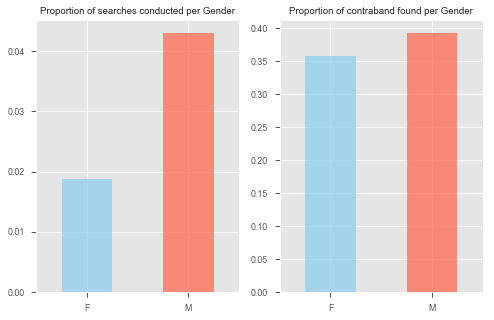

In [1306]:
# 1) MALE MORE LIKELY TO BE INSPECTED ?
# 2) MALE MORE LIKELY TO BE FOUND WITH CONTRABAND?

# 1)
fig = plt.subplots(1, 2, figsize=(8,5))
colors = ['skyblue','tomato']

plt.subplot(1,2,1)
search = df.groupby('driver_gender').search_conducted.mean()
search.plot(kind = 'bar', color = colors, alpha = 0.7, rot = 0)
plt.xlabel('')
plt.title('Proportion of searches conducted per Gender')


plt.subplot(1,2,2)
contraband = df[df.search_conducted == True].groupby('driver_gender').contraband_found.mean()
contraband.plot(kind = 'bar',color = colors, alpha = 0.7, rot = 0)
plt.xlabel('')
plt.title('Proportion of contraband found per Gender')


plt.show()

In [1307]:
# Male are searched more, but they are not found so that more than woman with contraband
# Attempt to confirm the consistency between search conducted over the age variable

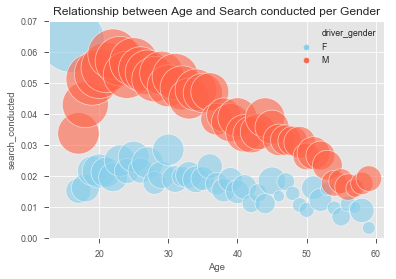

In [1308]:
# Mean of search conducted per Gender over the different ages
search = df.groupby(['driver_age','driver_gender']).search_conducted.mean()
search
# Mean of contraband found per Gender over the different ages
contraband = df.groupby(['driver_age','driver_gender']).contraband_found.mean()
contraband
# Concatenate the columns
search_contrab = pd.concat([search, contraband], axis = 'columns')
search_contrab.reset_index(inplace= True)
# Filter those < 60 where a difference between genders seem more consistent
search_contrab = search_contrab[search_contrab.driver_age < 60]

# Visualise scatterplot
sns.scatterplot(search_contrab.driver_age, search_contrab.search_conducted, hue = search_contrab.driver_gender, 
                palette = colors,s = search_contrab.contraband_found*100000, alpha = 0.6)

plt.ylim(0,0.07)
plt.title('Relationship between Age and Search conducted per Gender', fontsize = 12)
plt.xlabel('Age')
plt.show()

# The search seems to have a trend over time
# The contraband found seems tendentially stable 

### Analysis of Race across the other variable

In [1309]:
# GENDER AND RACE 

# Eliminate the catheory other
df = df[df.driver_race != 'Other']

# Cross tabulation between Gender and Race
cross = pd.crosstab(df.driver_gender, df.driver_race, normalize='index')

# Split the cross tabulation to create a split Heatmap between Male and Female
F = cross.iloc[:1,:]
F = F.rename(index={'F':'Stopped'}) # Modify so that when I join the Gender dataset I have diff. index
M = cross.iloc[1:2,:]
M = M.rename(index={'M':'Stopped'})

####################################

# Cross tabulation between Gender and Race for people arrested
b = b[b.driver_race != 'Other'] # b dataset was create earlier with only is_arrested == True

cross_a = pd.crosstab(b.driver_gender, b.driver_race, normalize='index') 
F_a = cross_a.iloc[:1,:]
F_a = F_a.rename(index={'F':'Arrested'})
M_a = cross_a.iloc[1:2,:]
M_a = M_a.rename(index={'M':'Arrested'})


# Concatenate arrested and stopped per gender/race
M = pd.concat([M,M_a], axis='rows')*100 # To give percentage values in the heatmap
F = pd.concat([F,F_a], axis='rows')*100


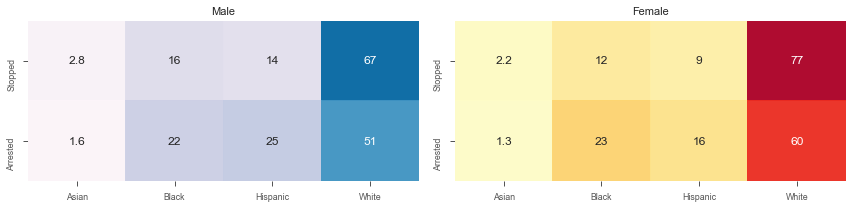

In [1310]:
fig = plt.subplots(1,2, figsize=(12,3))
plt.subplot(1,2,1)
heatmap  = sns.heatmap(M, annot=True, vmin=0, vmax=85, cmap="PuBu",
                      annot_kws={"size": 12}, alpha = 0.95, cbar=False) 
heatmap.set_title('',fontweight="bold") 
heatmap.set_xlabel('')
heatmap.set_ylabel('')
plt.title('Male', fontsize = 11)
heatmap
plt.subplot(1,2,2)
heatmap  = sns.heatmap(F, annot=True, vmin=0, vmax=85, cmap="YlOrRd",
                      annot_kws={"size": 12}, alpha = 0.95, cbar=False, ) 
heatmap.set_title('',fontweight="bold") 
heatmap.set_xlabel('')
heatmap.set_ylabel('')
heatmap
plt.title('Female', fontsize = 11)
plt.tight_layout()


plt.show()

### PROPORTION OF ARRESTED FOR EACH RACE COMPARED TO STOPPED FOR EACH RACE

Before we observed the proportion of people arrested between the different gender, so that for example we could say that 51% of Male arrested were white.
Now we observe how many of the stopped white are arrested. In other words, we verify the proportion of people arrested within each gender.

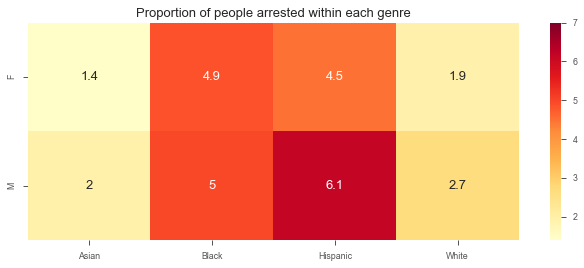

In [1311]:
sns.set_context("paper")
plt.figure(figsize=(11, 4))
cross = pd.crosstab(b.driver_gender, b.driver_race) # Crosstap within people arrested
cross1 = pd.crosstab(df.driver_gender,df.driver_race)  # Total number of people
cross2 = (cross / cross1)*100 # Proportion of people arrested for each genre

heatmap  = sns.heatmap(cross2, annot=True, vmin=1.4, vmax=7, cmap="YlOrRd", annot_kws={"size": 13}) 
heatmap.set_title('Proportion of people arrested within each genre', fontsize = 13) 
heatmap.set_xlabel('')
heatmap.set_ylabel('')
plt.show()

---

## Part 3: Temporal Analysis of the event

### Arrest annual Trend vs Stopping annual Trend

In [40]:
# Arrest
plt.subplot(2,1,1)
fm = df.is_arrested.resample('M').mean()
fa = df.is_arrested.resample('A').mean()
fm.plot(alpha = 0.35)
fa.plot(color = 'forestgreen')
fm.describe()
plt.xlim('2007','2015')
plt.title('Arrest Annual trend from 2007 to 2015', fontsize = 14)
plt.xlabel('Year', fontsize = 12)



# Stops
plt.subplot(2,1,2)
am = df.stops.resample('M').sum()
aa = df.stops.resample('A').sum()

aa.plot(color = 'goldenrod')
plt.title('Stopping Annual trend from 2007 to 2015', fontsize = 14)
plt.xlim('2007','2015')
plt.tight_layout()
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-40-0d6c684c7793>, line 13)

In [1314]:
# We can observe the curve related to arrest, indicated with grey, to be noisy. This may give an idea of seasonality inthe
# trend, which will be analysed in the following section.
# +

# Whenever the arrest rate has a peak, the stopping annual rate seems to decrease.

### Looking for seasonality: difference attitude toward different months

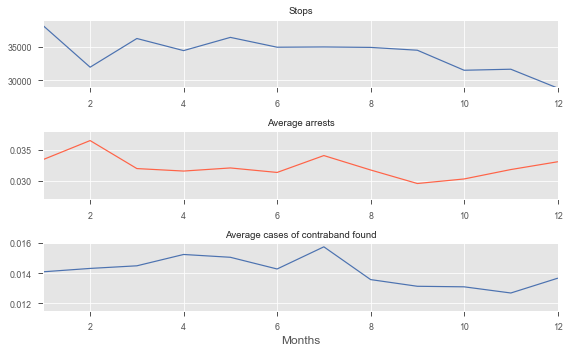

In [1315]:
fig = plt.subplots(3,1, figsize=(8,5))

mac = df.groupby(df.index.month).stops.count() # monthly accident count
plt.subplot(3,1,1)
mac.plot()
plt.ylim(29000,39000)
plt.xlim(1,12)
plt.xlabel('')
plt.title('Stops')


mar = df.groupby(df.index.month).is_arrested.mean() # monthly arrested mean
plt.subplot(3,1,2)
mar.plot(color = 'tomato')
plt.ylim(0.027,0.038)
plt.xlim(1,12)
plt.xlabel('')
plt.title('Average arrests')


mcf = df.groupby(df.index.month).contraband_found.mean() # monthly contraband found mean (# MAYBE IT INCREASES THE NUMBER OF CONTRABAND FOUND PERIODICALLY ?)
plt.subplot(3,1,3)
mcf.plot()
plt.ylim(0.0115,0.016)
plt.xlim(1,12)
plt.title('Average cases of contraband found')

#m = pd.concat([m, mcf], axis = 'columns')# Concatenate


plt.xlabel('Months', fontsize = 12)
plt.tight_layout()
plt.show()

### Different moment of the Day

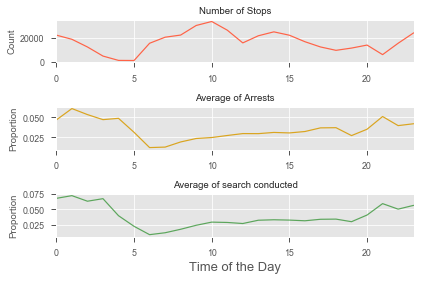

In [1316]:
hs = df.groupby(df.index.hour).stops.count()
ha = df.groupby(df.index.hour).is_arrested.mean()
hsc = df.groupby(df.index.hour).search_conducted.mean()

plt.subplot(3,1,1)
hs.plot(color = 'tomato')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Number of Stops')
plt.xlim(0,23)

plt.subplot(3,1,2)
ha.plot(color = 'goldenrod')
plt.xlim(0,23)
plt.xlabel('')
plt.ylabel('Proportion')
plt.title('Average of Arrests')
plt.tight_layout()

plt.subplot(3,1,3)
hsc.plot(color = 'forestgreen', alpha = 0.7)
plt.xlim(0,23)
plt.xlabel('Time of the Day', fontsize = 13)
plt.ylabel('Proportion')
plt.title('Average of search conducted')
plt.tight_layout()
plt.show()

### Weekday

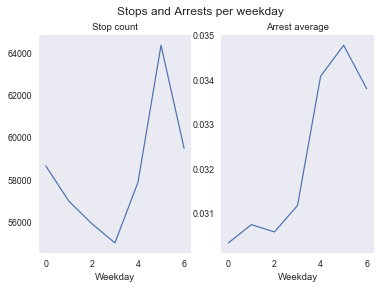

In [1327]:
ws = df.groupby(df.index.weekday).stops.count()
wa = df.groupby(df.index.weekday).is_arrested.mean()
plt.subplot(1,2,1)
ws.plot()
plt.title('Stop count')
plt.xlabel('Weekday')
plt.subplot(1,2,2)
wa.plot()
plt.title('Arrest average')
plt.xlabel('Weekday')

plt.suptitle('Stops and Arrests per weekday', fontsize = 12)

plt.show()

---

### Comparing the hour attitude towards each day of the Week

In [1329]:
b = b.set_index('stop_datetime')
aa = pd.crosstab(b.index.weekday_name,b.index.hour)
week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

aa.reset_index(inplace= True)
aa.row_0 = aa.row_0.astype(CategoricalDtype(ordered=True, categories= week))
aa.set_index('row_0', inplace= True)
aa = aa.sort_index()


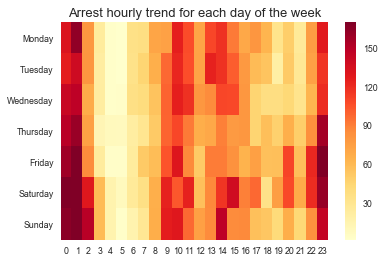

In [1330]:
heatmap  = sns.heatmap(aa, vmin=1.4, vmax=170, cmap="YlOrRd", annot_kws={"size": 13}) 
heatmap.set_title('Arrest hourly trend for each day of the week', fontsize = 13) 
heatmap.set_xlabel('')
heatmap.set_ylabel('')
plt.show()

---